# Problem 3 - State Estimation

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description
- <b>Consider a grid for which we have sufficient metering data <i>z<sub>meter</sub></i> and discover the state vector <i>x</i> that fully characterizes the condition in which the grid is being operated, given the grid static information of its structure and corresponding component models.<b>

    _______________________________________________________________________________________________________________________

Considered "Kite" 5 Bus Network
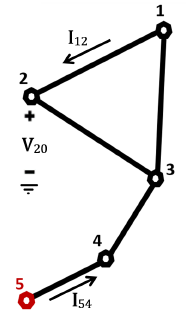

- <b>Implementation.<b>

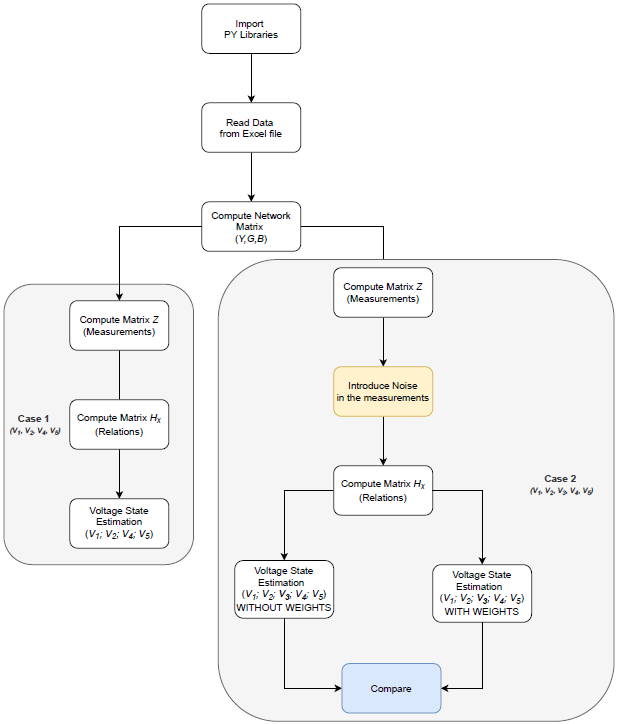

<b>Import Python Libraries

In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmath

Auxiliary function for visualization:

In [655]:
# visualize the results in vector form
def vector_form(vector, decimals):
    for i in range (vector.shape[0]):
        print("{0:+.{2}f}  {1:+.{2}f} i".format(vector[i].real, vector[i].imag, decimals))

<b>Parameters

In [656]:
networkFactor = 100    # To change the characteristics of the network (Y)
cosPhi=0.95            # Value of teta
m=100                  # Number of Iterations   
sig=0.5                # Noise factor 

<b>Import data (From Excel file)

In [657]:
Info = np.array(pd.read_excel (r'dataC3.xlsx', sheet_name='Info', header=None))
# Information about the slack bus
SlackBus=Info[0,1]
print ("Slack Bus: ", SlackBus,"\n")

# Network Information
Net_Info = np.array(pd.read_excel (r'dataC3.xlsx', sheet_name='Y_Data'))
print ("Lines information (Admitances)\n", Net_Info, "\n")

#Power Information (train)
Power_Info = np.array(pd.read_excel (r'dataC3.xlsx', sheet_name='Load(t,Bus)'))
Power_Info = np.delete(Power_Info,[0],1)
print ("Power consumption information (time, Bus) - (Train)\n", Power_Info, "\n")

time=Power_Info.shape[0]
P=np.dot(-Power_Info,np.exp(complex(0,1)*np.arccos(cosPhi)))
I=np.conj(P[2,:])

print(I)

Slack Bus:  5 

Lines information (Admitances)
 [[1 2 '0,01-0,1i']
 [1 3 '0,02-0,2i']
 [2 3 '0,03-0,2i']
 [3 4 '0,03-0,2i']
 [4 5 '0,02-0,2i']] 

Power consumption information (time, Bus) - (Train)
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]
 [0.684 0.528 0.256 0.44 ]] 

[-0.2128+0.06994398j -0.6726+0.22107293j -1.4934+0.49085684j
 -0.0684+0.02248199j]


<b>Admittance Matrix(Y); Conductance Matrix(G); Susceptance Matrix(B)

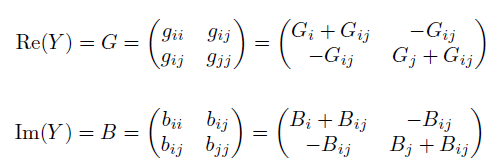

In [658]:
# Determine the number of Bus
nBus=max(np.max(Net_Info[:,0]),np.max(Net_Info[:,1]))

# Create the variable number of lines and the admitance matrix (Y)
nLines=Net_Info.shape[0]

Y=np.zeros((nBus,nBus), dtype=complex)

# Complete the Y matrix and update the number of lines
for i in range (Net_Info.shape[0]):
    y_aux=Net_Info[i,2].replace(",",".")
    y_aux=y_aux.replace("i","j")
    Y[Net_Info[i,0]-1,Net_Info[i,0]-1]=Y[Net_Info[i,0]-1,Net_Info[i,0]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,1]-1]=Y[Net_Info[i,1]-1,Net_Info[i,1]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,0]-1,Net_Info[i,1]-1]=Y[Net_Info[i,0]-1,Net_Info[i,1]-1]-complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,0]-1]=Y[Net_Info[i,1]-1,Net_Info[i,0]-1]-complex(y_aux)*networkFactor

            
# Remove the slack bus from the admitance matrix            
Yl=np.delete(Y, np.s_[SlackBus-1], axis=0)
Yl=np.delete(Yl, np.s_[SlackBus-1], axis=1)

# Conductance Matrix
G=Yl.real

# Susceptance Matrix
B=Yl.imag 

print("The admitance matrix Y is:\n", Y, "\n")
print("The conductance matrix G is\n", G, "\n")
print("The susceptance matrix B is\n",B, "\n")

The admitance matrix Y is:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]] 

The conductance matrix G is
 [[ 3. -1. -2.  0.]
 [-1.  4. -3.  0.]
 [-2. -3.  8. -3.]
 [ 0.  0. -3.  5.]] 

The susceptance matrix B is
 [[-30.  10.  20.   0.]
 [ 10. -30.  20.   0.]
 [ 20.  20. -60.  20.]
 [  0.   0.  20. -40.]] 



<b>1º State Estimation considering complete information about currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> (amplitude and angle) and not estimating <i>V<sub>3</sub></i>; Page 39

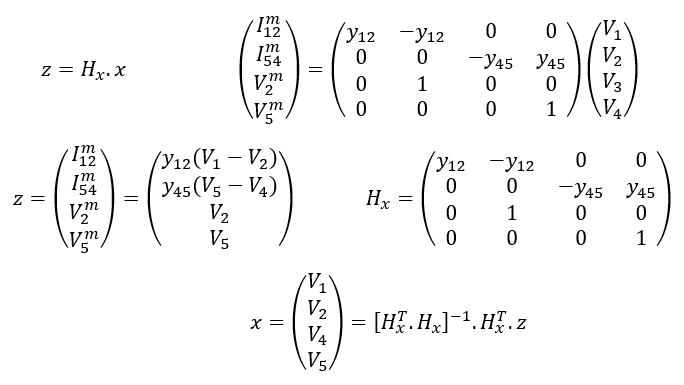

In [659]:
# Matrix Creation

# Z
b0s=np.zeros((4), dtype=np.complex_)
# Hx
# here I'm using np.matrix because np.array doesn't have the .H attribute
A0s=np.matrix(np.zeros((4,4), dtype=np.complex_)) 
# x
v0s=np.zeros((5), dtype=np.complex_)


# Voltage Computing (Reference)
v0s[0:4]=1+np.dot(np.linalg.inv(Yl),I)
v0s[4]=1


# Measurement values z 
b0s[0] = Y[0,1]*(v0s[0] - v0s[1])
b0s[1] = Y[3,4]*(v0s[4] - v0s[3])
b0s[2] = v0s[1]
b0s[3] = v0s[4]


# Matrix Hx 

A0s[0,0] = Y[0,1]
A0s[0,1] = -Y[0,1]
A0s[1,2] = -Y[3,4]
A0s[1,3] = Y[3,4]
A0s[2,1] = 1
A0s[3,3] = 1


# to Leonardo: before, we had ".T" but we're supposed to use ".H" (Hermitian conjugate)
# State Variables (x) - These variables are the estimated voltages (V1; V2; V4; V5)
x = np.linalg.inv(A0s.H@A0s)@A0s.H@b0s
x = np.array(x).flatten()

In [660]:
print("(incomplete) state vector x:\n")
vector_form(x,4)

(incomplete) state vector x:

+0.8851  -0.2433 i
+0.8796  -0.2539 i
+0.9481  -0.1172 i
+1.0000  +0.0000 i


<b>2º State Estimation considering RMS information of currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> and estimating <i>V<sub>3</sub></i>. Page 41
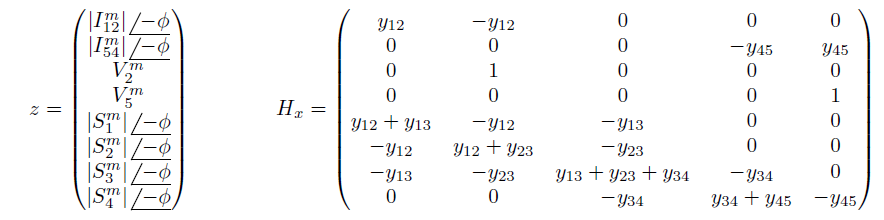

In [661]:
# Matrix Creation
b0=np.zeros((8), dtype=np.complex_)
b1=np.zeros((8), dtype=np.complex_)
b2=np.zeros((8), dtype=np.complex_)
A=np.matrix(np.zeros((8,5), dtype=np.complex_))
v=np.zeros((5), dtype=np.complex_)

# Voltage Computing (Reference)
v[0:4]=1+np.dot(np.linalg.inv(Yl),I)
v[4]=1

# Measurement values z (In that case, we are computing the currents and voltages but we can also measure them).
b0[0]=np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
b0[1]=np.dot(np.absolute(np.dot(-Y[3,4],(1-v[3]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
b0[2]=v[1]
b0[3]=1
b0[4:8]=I #In that case, we are also including the vectors of aparente power

# Matrix Hx (Page 41)
A[0,0] = Y[0,1]
A[0,1] = -Y[0,1]
A[1,3] = -Y[3,4]
A[1,4] = Y[3,4]
A[2,1] = 1
A[3,4] = 1
A[4,0] = Y[0,1] + Y[0,2]
A[4,1] = -Y[0,1]
A[4,2] = -Y[0,2]
A[5,0] = -Y[0,1]
A[5,1] = Y[0,1] + Y[1,2]
A[5,2] = -Y[1,2]
A[6,0] = -Y[0,2]
A[6,1] = -Y[1,2]
A[6,2] = Y[0,2] + Y[1,2] + Y[2,3]
A[6,3] = -Y[2,3]
A[7,2] = -Y[2,3]
A[7,3] = Y[2,3] + Y[3,4]
A[7,4] = -Y[3,4]



<b>2º a) - First, the weight of pseudo-measurements (Matrix W) <u>are not considered</u>;

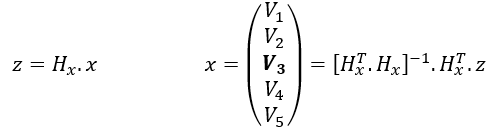

In [662]:
x = np.linalg.inv(A.H@A)@A.H@b0
x = np.array(x).flatten()

In [663]:
vector_form(x,4)
print("")
vector_form(v,4)

+0.9939  -0.0120 i
+0.9993  -0.0015 i
+0.9869  -0.0270 i
+0.9318  -0.1362 i
+0.8804  -0.2524 i

+0.8851  -0.2433 i
+0.8796  -0.2539 i
+0.8924  -0.2278 i
+0.9481  -0.1172 i
+1.0000  +0.0000 i


In [664]:
vector_form(x,4)
print("")
vector_form(v,4)

+0.9939  -0.0120 i
+0.9993  -0.0015 i
+0.9869  -0.0270 i
+0.9318  -0.1362 i
+0.8804  -0.2524 i

+0.8851  -0.2433 i
+0.8796  -0.2539 i
+0.8924  -0.2278 i
+0.9481  -0.1172 i
+1.0000  +0.0000 i


In [665]:
sig = 0.5 # noise standard deviation

# function for changing H according to the pseudo-measurements used
def submatrix(matrix, index_list, rowOrCol):
    if rowOrCol == "row":
        submatrix = np.concatenate((matrix[:4], matrix[index_list,:]), axis=0)
    if rowOrCol == "col":
        submatrix = np.concatenate((matrix[:,:4], matrix[:,index_list]), axis=1)
    return submatrix

# same but for vectors z
def subvector(vector, index_list):
    subvector = np.concatenate((vector[:4], vector[index_list]), axis=0)
    return subvector

# automatizing the process
def state_estimate(Y, cosPhi, A, I, m, sig, weightedQ, pm_used):

    # changing matrix H depending on the pseudo-measurements used
    pm_used = [x + 4 - 1 for x in pm_used] # adjusting such that each index will relay to its position in the matrix H
    # the - 1 is for it to be aligned with S_1, S_2, S_3, S_4
    A = submatrix(A, pm_used, "row")

    # deciding right away if we want to use the weighted Q matrix or not
    Wdiag=np.array([10**6,10**6,10**6,10**6,4,4,4,4])
    W=np.diag(Wdiag)
    W = submatrix(W, pm_used, "row")
    W = submatrix(W, pm_used, "col")
    # conditions for such question
    if weightedQ==True:
        aux_estimation = np.linalg.inv(A.H@W@A)@A.H@W
    else:
        if weightedQ==False:
            aux_estimation = np.linalg.inv(A.H@A)@A.H
        else:
            print("Error: weightedQ must be True or False")
            return None

    # noise to be added to pseudo-measurements
    e = np.random.normal(0.0, 1.0, size=(len(pm_used),m))*sig

    # initializing z vectors
    b0=np.zeros((8), dtype=np.complex_)
    b1=np.zeros((8), dtype=np.complex_)
    v=np.zeros((5), dtype=np.complex_)

    # Voltage Computing (Reference)
    v[0:4]=1+np.dot(np.linalg.inv(Yl),I)
    v[4]=1

    # Measurement values z (In that case, we are computing the currents and voltages but we can also measure them).
    b0[0]=np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
    b0[1]=np.dot(np.absolute(np.dot(-Y[3,4],(1-v[3]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
    b0[2]=v[1]
    b0[3]=1
    b0[4:8]=I #In that case, we are also including the vectors of aparente power
    
    # reproduce previous z vector
    b1 =  b0.copy()
    
    # refactor b0 and b1
    b0 = subvector(b0, pm_used)
    b1 = subvector(b1, pm_used)

    # Initial estimation of the voltages
    x0 = aux_estimation@b0
    x0 = np.array(x0).flatten()

    
    # Matrix creation
    sx=np.zeros(5)
    rms=np.zeros((5,m))
    ei12a=np.zeros(m)
    ei54a=np.zeros(m)
    
    for i in range(m):
        # Introduce error in the measurements (Matrix z) ]
        b1[4:] = b0[4:] + e[:,i]
        # Estimate the voltages based on measurements with the errors
        x = aux_estimation@b1
        x = np.array(x).flatten()

        # Accumulated value of estimations
        sx=sx+x

        # Errors in the voltages
        rms[:,i]=np.sqrt(np.dot((x-x0),np.conjugate(x-x0))) 
        
        # x0 is the initial estimation not considering the noise 
        # x is the estimation considering the noise 

        #Relative current errors (To be used in the graphics)
        ei12a[i]=np.divide(np.absolute(np.dot(Y[0,1],(x[0]-x[1])))-np.absolute(np.dot(Y[0,1],(v[0]-v[1]))),np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
        ei54a[i]=np.divide(np.absolute(np.dot(Y[3,4],(1-x[3])))-np.absolute(np.dot(Y[3,4],(1-v[3]))),np.absolute(np.dot(Y[3,4],(1-v[3]))))
    
    #Average Voltage Estimation
    x_avg=sx/m

    #Average Voltage RMS Error
    ee=np.transpose(np.matrix,sum(np.transpose(rms)))/m

    return x_avg, ee, ei12a, ei54a


x_avg, ee, ei12a, ei54a = state_estimate(Y, cosPhi, A, I, m, sig,weightedQ=False,pm_used=[1,2,3,4])

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2724940073.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  rms[:,i]=np.sqrt(np.dot((x-x0),np.conjugate(x-x0)))


In [666]:
vector_form(x_avg, 4)
print("")
vector_form(v, 4)

+0.9939  -0.0125 i
+0.9992  -0.0022 i
+0.9867  -0.0282 i
+0.9317  -0.1375 i
+0.8804  -0.2517 i

+0.8851  -0.2433 i
+0.8796  -0.2539 i
+0.8924  -0.2278 i
+0.9481  -0.1172 i
+1.0000  +0.0000 i


Primeiro scatter plot só "sem weight"

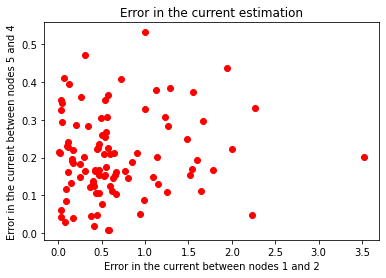

In [667]:
def scatter_plot_error(ei12a, ei54a, m):
    plt.scatter(ei12a, ei54a, marker='o', color='r')
    plt.title('Error in the current estimation')
    plt.xlabel('Error in the current between nodes 1 and 2')
    plt.ylabel('Error in the current between nodes 5 and 4')
    plt.show()

scatter_plot_error(np.absolute(ei12a), np.absolute(ei54a), m)

<b>2º b) - Second, the weight of pseudo-measurements (Matrix W) <u>are considered</u>;
    
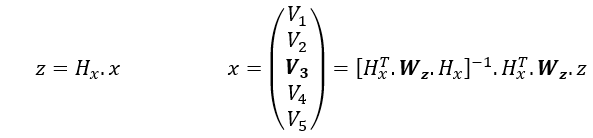

In [668]:
# the process has been automatized, thus, we can use the same function but with weightedQ=True

x_avgW, eeW, ei12aW, ei54aW = state_estimate(Y, cosPhi,A, I, m, sig,weightedQ=True,pm_used=[1,2,3,4])

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2724940073.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  rms[:,i]=np.sqrt(np.dot((x-x0),np.conjugate(x-x0)))


Lonely scatterplot

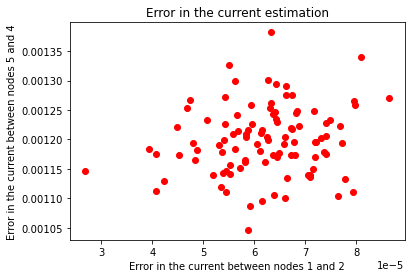

In [669]:
scatter_plot_error(np.absolute(ei12aW), np.absolute(ei54aW), m)

<b>Plot Results

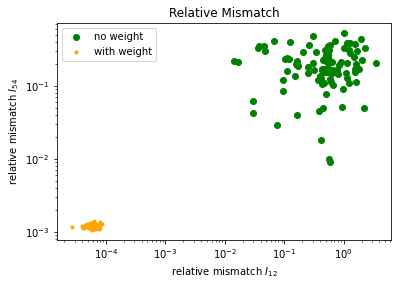

In [670]:
# same but legends upper left corner
def scatter_plot_error_cool(ei12a, ei54a, ei12aW, ei54aW, m):
    plt.scatter(ei12a, ei54a, marker='o', color='green', label='no weight')
    plt.scatter(ei12aW, ei54aW, marker='.', color='orange', label='with weight')
    plt.title('Relative Mismatch')
    plt.xlabel('relative mismatch $I_{12}$')
    plt.ylabel('relative mismatch $I_{54}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()


scatter_plot_error_cool(np.absolute(ei12a), np.absolute(ei54a), np.absolute(ei12aW), np.absolute(ei54aW), m)

# Extra Project Goals
Think about an interesting variation to this problem or a different way to solve and implement it !!!

Some ideas:
- Assume you have to chose just two out of four possible pseudo-measurements, S<sup>m</sup><sub>1</sub> , S<sup>m</sup><sub>2</sub> , S<sup>m</sup><sub>3</sub> , S<sup>m</sup><sub>4</sub> . What would be your choices and why? Choose based on probable accuracy of the resulting estimation.
- Assume that <i>I<sub>12</sub>=0</i>. Under this assumption, one of two possible situations may be occuring: either branch 1-2 is out of service (<i>y<sub>12</sub>=0</i>) or the corresponding current meter is malfunctioning. Decide about the most probable situation based on the accuracy of the corresponding estimation. as in the previous exercice, use the matrix <i>R<sub>x</sub></i> andd consider different matrices <i>W<sub>z</sub></i> including the identity matrix. Elaborate on the effects of <i>W<sub>z</sub></i>.  


Challenge 1: picking the best 2 pseudo-measurements.

In [671]:
# basing it on sensitivity parameter, which expresses the standard error for 
#the estimated state variable, the higher the better
def pseudo_sensitivity(matrix_H,I):
    n = matrix_H.shape[0]-4
    sensitivity = np.zeros(n) # i.e. all but the first 4
    for i in range(len(I)):
        sensitivity[i] = np.sqrt(np.linalg.inv(matrix_H.T @ matrix_H)[i,i])
    return sensitivity

sensitivity = pseudo_sensitivity(A, I)
for i in range(len(sensitivity)):
    print('sensitivity regarding S_{}:'.format(i+1), sensitivity[i])


# same but only using the submatrix regarding the pseudomeasurements
def pseudo_sensitivity_submatrix(matrix_H):
    matrix_H = matrix_H[4:,:]
    sensitivity = np.zeros(matrix_H.shape[0]) # i.e. all but the first 4
    for i in range(matrix_H.shape[0]):
        sensitivity[i] = np.sqrt(np.linalg.inv(matrix_H.T @ matrix_H)[i,i])
    return sensitivity

sensitivity = pseudo_sensitivity_submatrix(A)
print('')
print(' now using the submatrix\n')
for i in range(len(sensitivity)):
    print('sensitivity regarding S_{}:'.format(i+1), sensitivity[i])



sensitivity regarding S_1: 0.7046813005319357
sensitivity regarding S_2: 0.7050745211270305
sensitivity regarding S_3: 0.7060878297367532
sensitivity regarding S_4: 0.706437318518691

 now using the submatrix

sensitivity regarding S_1: 456394.20800167206
sensitivity regarding S_2: 456394.208001672
sensitivity regarding S_3: 456394.20800167246
sensitivity regarding S_4: 456394.2080016719


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2138008194.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  sensitivity[i] = np.sqrt(np.linalg.inv(matrix_H.T @ matrix_H)[i,i])
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2138008194.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  sensitivity[i] = np.sqrt(np.linalg.inv(matrix_H.T @ matrix_H)[i,i])


Now we do it again the suggested pseudomeasurements.

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2724940073.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  rms[:,i]=np.sqrt(np.dot((x-x0),np.conjugate(x-x0)))


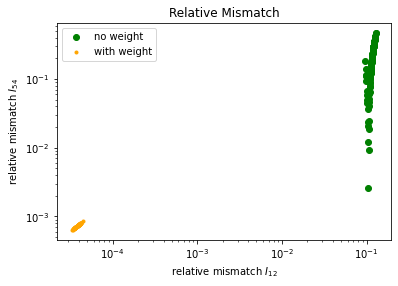

In [672]:
# now we can use the best 2 pseudo measurements to estimate the state
pseudo_measurements = [3,4] # best two picked "by hand"
x_avgPseudo1, eePseudo1, ei12aPseudo1, ei54aPseudo1 = state_estimate(Y, cosPhi, A, I, m, sig,weightedQ=False,pm_used= pseudo_measurements)
x_avgW_Pseudo1, eeW_Pseudo1, ei12aW_Pseudo1, ei54aW_Pseudo1 = state_estimate(Y, cosPhi,A, I, m, sig,weightedQ=True,pm_used=pseudo_measurements)

# scatter
scatter_plot_error_cool(np.absolute(ei12aPseudo1), np.absolute(ei54aPseudo1), np.absolute(ei12aW_Pseudo1), np.absolute(ei54aW_Pseudo1), m)

In [689]:
# heat map just like MatrixPlot from Mathematica
def matrix_plot(matrix):
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.show()

# same but with bar on the side
def matrix_plot_bar(matrix):
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()




def correlation_matrix(matrix_H):
    '''
    matrix_H: jacobian matrix

    we will actually only use its last n rows, where n is the number of pseudo measurements

    returns: correlation matrix
    '''
    matrix_H = matrix_H[4:,:]
    matrix_H = np.array(matrix_H)
    correlation = np.zeros(matrix_H.shape)
    for i in range(matrix_H.shape[0]):
        sum_i=np.sum(matrix_H[i,:]**2)
        for j in range(matrix_H.shape[1]):
            sum_j=np.sum(matrix_H[:,j]**2)
            correlation[i,j] = matrix_H[i,j]/(np.sqrt(sum_i)*np.sqrt(np.sum(sum_j)))
    return correlation

correlation = correlation_matrix(A)

# print correlation matrix
print('correlation matrix:\n', correlation)


def corr_2_pseudo(c_matrix):
    n_pseudo = c_matrix.shape[0]

    corr_avg = np.zeros(n_pseudo)
    for i in range(n_pseudo):
        corr_avg[i] = c_matrix[i,:].mean()

    print('average correlation:\n', corr_avg)
    

    corr_between_two = np.zeros((n_pseudo, n_pseudo))
    for i in range(n_pseudo):
        for j in range(n_pseudo):
            corr_between_two[i,j] = (corr_avg[i]+corr_avg[j])/2
    
    return corr_between_two

corr_between_two = corr_2_pseudo(correlation)

# print correlation between each pair of pseudo measurements
print('correlation matrix:\n', np.abs(corr_between_two))
            
# picking the best 2 pseudo measurements
corr_between_two = np.abs(corr_between_two) # we don't care about the sign
# but we don't want to pick the same pseudo measurement twice
np.fill_diagonal(corr_between_two, 0) 
# now we can pick the best 2 pseudo measurements
argmax = np.argmax(corr_between_two)
best_x, best_y = np.unravel_index(argmax, corr_between_two.shape)

print('best pseudo measurements: S_{} and S_{}'.format(best_x, best_y))


correlation matrix:
 [[-0.00212164  0.00095207  0.00101092 -0.         -0.        ]
 [ 0.00095207 -0.00290512  0.00090673 -0.         -0.        ]
 [ 0.00101092  0.00090673 -0.00163821  0.00072333 -0.        ]
 [-0.         -0.          0.00063217 -0.00233504  0.00251305]]
average correlation:
 [-3.17304862e-05 -2.09265214e-04  2.00554043e-04  1.62036098e-04]
correlation matrix:
 [[3.17304862e-05 1.20497850e-04 8.44117782e-05 6.51528058e-05]
 [1.20497850e-04 2.09265214e-04 4.35558599e-06 2.36145583e-05]
 [8.44117782e-05 4.35558599e-06 2.00554043e-04 1.81295070e-04]
 [6.51528058e-05 2.36145583e-05 1.81295070e-04 1.62036098e-04]]
best pseudo measurements: S_2 and S_3


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\1426316274.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  correlation[i,j] = matrix_H[i,j]/(np.sqrt(sum_i)*np.sqrt(np.sum(sum_j)))


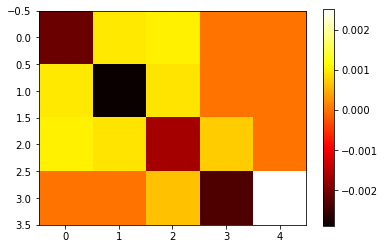

In [690]:
matrix_plot_bar(correlation)

Now, we do it again with the propposed best pseudo measurements.

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_19200\2724940073.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  rms[:,i]=np.sqrt(np.dot((x-x0),np.conjugate(x-x0)))


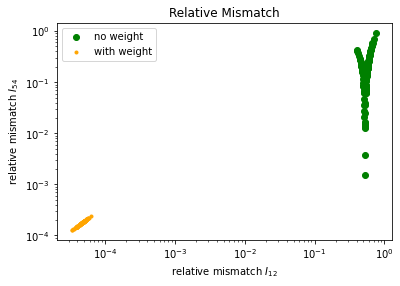

In [674]:
# now we can use the best 2 pseudo measurements to estimate the state
pseudo_measurements = [2,3] # [best_x, best_y]
x_avgPseudo2, eePseudo2, ei12aPseudo2, ei54aPseudo2 = state_estimate(Y, cosPhi, A, I, m, sig,weightedQ=False,pm_used= pseudo_measurements)
x_avgW_Pseudo2, eeW_Pseudo2, ei12aW_Pseudo2, ei54aW_Pseudo2 = state_estimate(Y, cosPhi,A, I, m, sig,weightedQ=True,pm_used=pseudo_measurements)

# scatter
scatter_plot_error_cool(np.absolute(ei12aPseudo2), np.absolute(ei54aPseudo2), np.absolute(ei12aW_Pseudo2), np.absolute(ei54aW_Pseudo2), m)


In [675]:
# error of our state estimation
# use L2 norm, as long as it applies to complex vectors as well
def error_approximation(x, v):
    '''
    x: true state
    v: estimated state
    '''
    return np.linalg.norm(x-v)

# use percentual error
def error_approximation(x, v):
    '''
    x: true state
    v: estimated state
    '''
    return np.linalg.norm(x-v)/np.linalg.norm(x)


# use it
print('error of our state estimation:\n')
print('without weighting, all pms:', error_approximation(x_avg, v))
print('without weighting, best 2 pms 1st:', error_approximation(x_avgPseudo1, v))
print('without weighting, best 2 pms 2nd:', error_approximation(x_avgPseudo2, v))
print('with weighting, all pms:', error_approximation(x_avgW, v))
print('with weighting, best 2 pms 1st:', error_approximation(x_avgW_Pseudo1, v))
print('with weighting, best 2 pms 2nd:', error_approximation(x_avgW_Pseudo2, v))



# now just the ee (rms average)
print('error of our state estimation:\n')
print('without weighting, all pms:', np.sqrt(np.mean(np.abs(ee)**2)))
print('without weighting, best 2 pms 1st:', np.sqrt(np.mean(np.abs(eePseudo1)**2)))
print('without weighting, best 2 pms 2nd:', np.sqrt(np.mean(np.abs(eePseudo2)**2)))
print('with weighting, all pms:', np.sqrt(np.mean(np.abs(eeW)**2)))
print('with weighting, best 2 pms 1st:', np.sqrt(np.mean(np.abs(eeW_Pseudo1)**2)))
print('with weighting, best 2 pms 2nd:', np.sqrt(np.mean(np.abs(eeW_Pseudo2)**2)))


   


error of our state estimation:

without weighting, all pms: 0.23992052381684636
without weighting, best 2 pms 1st: 0.24016365255685557
without weighting, best 2 pms 2nd: 0.23021766462237905
with weighting, all pms: 0.13278425734338525
with weighting, best 2 pms 1st: 0.14112844822090292
with weighting, best 2 pms 2nd: 0.12929518198150625
error of our state estimation:

without weighting, all pms: 0.03464004874386597
without weighting, best 2 pms 1st: 0.03492582082787419
without weighting, best 2 pms 2nd: 0.05715267123223354
with weighting, all pms: 0.0061273621563903945
with weighting, best 2 pms 1st: 0.006028970412024669
with weighting, best 2 pms 2nd: 0.006422180121035004
